# ParFlow Short Course: Gridding
## Exercise: Gridding with a Box Domain

### Domain Description
We will be working with a simple rectangular box domain. The initial domain is 20 cells long, 1 cell wide, and 10 cells deep (20 x 1 x 10).

### Topics Covered
1. Spatial Gridding
2. Temporal Gridding
3. Block Domain vs. Solid File Domain

## Topic 1: Spatial Gridding

### Activities
You will explore how different spatial grid conditions affect the conditions of a ParFlow run. The following notebook cells set up a ParFlow run by importing a ParFlow run definition, run ParFlow for 100 timesteps, and visualize the resulting ParFlow run grid. Please see [name/link to other notebook] if you would like to see the full set of keys used to define the domain for this ParFlow run. In this section we are focusing on the ParFlow keys related to the [Computational Grid](https://parflow.readthedocs.io/en/latest/keys.html#computational-grid), [Domain Geometry](https://parflow.readthedocs.io/en/latest/keys.html#geometries), and [dz Multipliers](https://parflow.readthedocs.io/en/latest/keys.html#dzmultipliers). We will explain these keys in more detail in the cells below. Also feel free to explore the [ParFlow manual](https://parflow.readthedocs.io/en/latest/keys.html#) for detail on all ParFlow keys.

We'd like for you to first run the notebook cells in this section as-is to see the default box domain visualized. Then you will experiment with changing several of the ParFlow keys to see how the resulting grid changes.

Please complete the following:
1. Run the following notebook cells in this section as-is. What characteristics do you notice about the grids presented in the plots?  
1. Experiment with changing the number and size of the grid cells by redefining the related ParFlow keys and re-running the notebook. How does the ParFlow grid change as a result?  
    1. Keys for the number of grid cells: `ComputationalGrid.NX`, `ComputationalGrid.NY`, `ComputationalGrid.NZ`
    1. Keys for the size of grid cells: `ComputationalGrid.DX`, `ComputationalGrid.DY`, `ComputationalGrid.DZ`
1. Experiment with restricting only part of the domain to be in the "active" region. This means that the ParFlow grid only considers this region when solving. Do this by setting `Geom.domain.Upper.X` to be half of what it was previously. Re-run the notebook cells and notice how the ParFlow grid changes as a result.
1. Experiment with defining a variable dz. This can be done by setting the ParFlow key `Solver.Nonlinear.VariableDz` to `True`. We have defined some depth levels in the ParFlow keys `Cell._0.dzScale.Value` to `Cell._9.dzScale.Value`. Compare the visual of the grid before and after this change is made. What do you notice about the resulting grid cell spacing?

In [1]:
# Import the ParFlow package
from parflow import Run
import os
import shutil
from parflow.tools.fs import mkdir, cp, chdir, get_absolute_path, rm, exists

# Import run information from pfidb
domain_example = Run.from_definition("output/domain_example.pfidb")

In [ ]:
#-----------------------------------------------------------------------------
# Computational Grid
#-----------------------------------------------------------------------------

# Coordinates (length units)
# Locate the origin in the domain.
domain_example.ComputationalGrid.Lower.X = 0.0
domain_example.ComputationalGrid.Lower.Y = 0.0
domain_example.ComputationalGrid.Lower.Z = 0.0

# Cell size (length units)
domain_example.ComputationalGrid.DX      = 100.0
domain_example.ComputationalGrid.DY      = 2.0
domain_example.ComputationalGrid.DZ      = 1.0

# Grid dimensions (integer)
domain_example.ComputationalGrid.NX      = 20
domain_example.ComputationalGrid.NY      = 1
domain_example.ComputationalGrid.NZ      = 10

#-----------------------------------------------------------------------------
# Domain Geometry Input
#-----------------------------------------------------------------------------
domain_example.GeomInput.domain_input.InputType = 'Box'
domain_example.GeomInput.domain_input.GeomName  = 'domain'

#-----------------------------------------------------------------------------
# Domain Geometry
#-----------------------------------------------------------------------------
domain_example.Geom.domain.Lower.X = 0.0
domain_example.Geom.domain.Lower.Y = 0.0
domain_example.Geom.domain.Lower.Z = 0.0

domain_example.Geom.domain.Upper.X = 2000.0
domain_example.Geom.domain.Upper.Y = 2.0
domain_example.Geom.domain.Upper.Z = 10.0

domain_example.Geom.domain.Patches = 'x_lower x_upper y_lower y_upper z_lower z_upper'

#--------------------------------------------
# Variable dz Assignments
#------------------------------------------
domain_example.Solver.Nonlinear.VariableDz = False
domain_example.dzScale.GeomNames           = 'domain'
domain_example.dzScale.Type                = 'nzList'
domain_example.dzScale.nzListNumber        = 10

# cells start at the bottom (0) and moves up to the top
# domain is 49m thick, root zone is down to 4 cells 
# so the root zone is 2m thick
domain_example.Cell._0.dzScale.Value  = 10.0   # 10*1.0 = 10m  layer
domain_example.Cell._1.dzScale.Value  = 10.0   
domain_example.Cell._2.dzScale.Value  = 10.0   
domain_example.Cell._3.dzScale.Value  = 10.0
domain_example.Cell._4.dzScale.Value  = 5.0
domain_example.Cell._5.dzScale.Value  = 1.0
domain_example.Cell._6.dzScale.Value  = 1.0
domain_example.Cell._7.dzScale.Value  = 0.6   # 0.6*1.0 = 0.6  60cm 3rd layer
domain_example.Cell._8.dzScale.Value  = 0.3   # 0.3*1.0 = 0.3  30cm 2nd layer
domain_example.Cell._9.dzScale.Value  = 0.1   # 0.1*1.0 = 0.1  10cm top layer

#-----------------------------------------------------------------------------
# Run ParFlow
#-----------------------------------------------------------------------------
base = os.path.join(os.getcwd(), "output")
mkdir(base)
print(f"base: {base}")
domain_example.run(working_directory=base)

Now let's take a look at the ParFlow grid. We will visualize how saturation and pressure vary within the defined grid. No need to change any of the code below, just run these cells after the ParFlow run in the previous cell completes and take a look at the output plots.

In [15]:
import parflow as pf
import numpy as np  # we will use numpy to work with the data
import matplotlib.pyplot as plt  # we will use matplotlib to plot the data
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

def plot_domain(run_directory, variable, timestep=0):
    """Function to plot output from a ParFlow run"""

    # Load the run from the file, this is the same as the run defined above
    run = Run.from_definition(os.path.join(run_directory, "domain_example.pfidb"))   

    data = run.data_accessor # get the data accessor, this makes it easier to access the data from the run
    nt = len(data.times)  # get the number of time steps
    nx = data.shape[2]    # get the number of cells in the x direction
    ny = data.shape[1]    # get the number of cells in the y direction
    nz = data.shape[0]    # get the number of cells in the z direction
    dx = data.dx          # get the cell size in the x direction
    dy = data.dy          # get the cell size in the y direction
    dz = data.dz          # get the cell size in the z direction, this is a 1D array of size nz

    # Print a summary of the run data
    print(f"nx = {nx}, ny = {ny}, nz = {nz}, nt = {nt}")
    print(f"dx = {dx}, dy = {dy}, dz = {dz}")

    # Load the data
    data = read_pfb(get_absolute_path(f"domain_example.out.{variable}.{str(timestep).zfill(5)}.pfb")).reshape(nrows, ncols)
    
    # Set negative saturation values to NaN
    if variable == "satur":
        data[data < 0.0] = np.nan
    
    # Set up x and z to match the shape of the ParFlow grid
    x = np.arange(0.0,(nx+1)*dx,dx)
    z = np.zeros(nz+1)
    z[1:] = np.cumsum(dz)

    # Get limits for plotting
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    print(f"vmin: {vmin}, vmax: {vmax}")
    
    # Define labels for plots
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head"

    # Use pcolormesh to plot the data with the x and z coordinates with lines 
    # for the grid mesh from the ParFlow run grid
    fig, ax = plt.subplots()
    im = ax.pcolormesh(x, z, data, vmin=vmin, vmax=vmax, cmap='plasma_r')
    plt.colorbar(im, ax=ax, label=label)
    
    # Include mesh lines
    ax.hlines(z,x[0],x[-1],colors='white',linewidth=0.5)
    ax.vlines(x,z[0],z[-1],colors='white',linewidth=0.5)
    
    ax.set_xlabel('x [m]')
    ax.set_ylabel('z [m]')
    ax.set_title(f"{title} at t={timestep}")
    plt.show()

nx = 20, ny = 1, nz = 10, nt = 101
dx = 100.0, dy = 2.0, dz = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
vmin: 0.28374782761443423, vmax: 0.9155417527999328


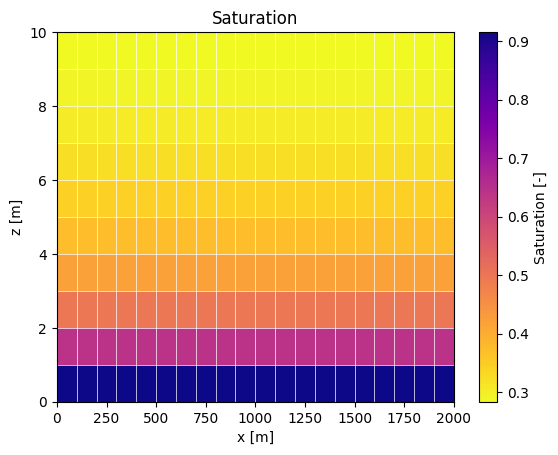

nx = 20, ny = 1, nz = 10, nt = 101
dx = 100.0, dy = 2.0, dz = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
vmin: -9.5, vmax: -0.5


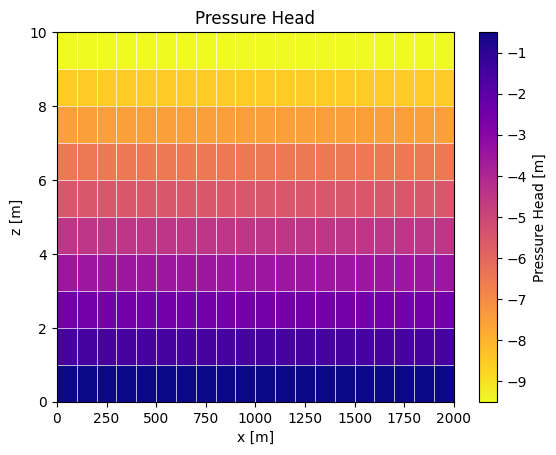

In [16]:
# Call plotting function for saturation and pressure
plot_domain(base, "satur", timestep=0)
plot_domain(base, "press", timestep=0)

## Topic 2: Temporal Gridding

### Activities
You will explore how different temporal grid conditions affect the conditions of a ParFlow run. The following notebook cells set up a ParFlow run by importing a ParFlow run definition, run ParFlow for 100 timesteps, and visualize the resulting ParFlow run grid. Please see [name/link to other notebook] if you would like to see the full set of keys used to define the domain for this ParFlow run. In this section we are focusing on the ParFlow keys related to [Timing](https://parflow.readthedocs.io/en/latest/keys.html#timing-information). We will explain these keys in more detail in the cells below. Also feel free to explore the [ParFlow manual](https://parflow.readthedocs.io/en/latest/keys.html#) for detail on all ParFlow keys.

We'd like for you to first run the notebook cells in this section as-is to see the default box domain visualized. Then you will experiment with changing several of the ParFlow keys to see how the resulting grid changes.

Please complete the following:
1. Run the following notebook cells in this section as-is. What characteristics do you notice about the grids presented in the plots?  
1. Experiment with changing the start and stop times for the run using the keys `TimingInfo.StartTime` and `TimingInfo.StopTime`. Review the time series plot and compare how the outputs change as these key values change.

In [ ]:
#-----------------------------------------------------------------------------
# Setup Timing
#-----------------------------------------------------------------------------

# Sets time units for time cycles (T)
domain_example.TimingInfo.BaseUnit     = 1.0

# Initial output file number
domain_example.TimingInfo.StartCount   = 0

# Start and finish time for simulation (T)
domain_example.TimingInfo.StartTime    = 0.0
domain_example.TimingInfo.StopTime     = 100.0

# Interval to write output (T) -1 outputs at every timestep
domain_example.TimingInfo.DumpInterval = 1.0

# Timestep type
domain_example.TimeStep.Type           = 'Constant'

# Delta T (T)
domain_example.TimeStep.Value          = 1.0

#-----------------------------------------------------------------------------
# Run ParFlow
#-----------------------------------------------------------------------------
base = os.path.join(os.getcwd(), "output")
mkdir(base)
print(f"base: {base}")
domain_example.run(working_directory=base)

Talk about what they should see in these plots...

In [ ]:
# Call plotting function at multiple timesteps
timesteps = [0, 5, 10]

for t in timesteps:
    plot_domain(base, "satur", timestep=t)

## Topic 3: Working from a Solid File

### Activities

Please complete the following:
1. 

In [ ]:
# Declare the geometries that you will use for the problem
model.GeomInput.Names = "solid_input"

# Define the solid_input geometry.  
# Note the naming convention here GeomInput.{GeomName}.key
model.GeomInput.solid_input.InputType = "SolidFile"
model.GeomInput.solid_input.GeomNames = "domain"
model.GeomInput.solid_input.FileName = "LW.pfsol"